In [0]:
from PIL import Image
import torch
import torch.optim as optim
import torchvision as tv
import torch.utils.data as tud
import torch.nn as nn
import torch.nn.functional as F

import numpy as np
import random
import matplotlib.pyplot as plt

from tqdm.auto import tqdm

In [0]:
SEED = 1234

random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

In [0]:
class ZSSRDataset(tud.Dataset):
    def __init__(self, IMG_PATH, sr_factor=2, transforms=None):
        super(ZSSRDataset, self).__init__()
        self.img = Image.open(IMG_PATH)
        self.srf = sr_factor
        self.transforms = transforms
        
        self.factors = self.calculate_intermediate_sr()
        self.hr_lr_pairs = self.generate_hr_lr_pairs()
        
    def __len__(self):
        return len(self.hr_lr_pairs)
    
    def __getitem__(self, idx):
        return self.hr_lr_pairs[idx]
        
    def generate_hr_lr_pairs(self):
        hr_lr_pairs = []

        # # DGB
        # self.factors = [1]
        for srf in self.factors:
            hr = self.img.resize((int(self.img.size[0] * srf), int(self.img.size[1] * srf)),
                                 Image.BICUBIC)
            lr = self.img.resize((hr.size[0] // self.srf, hr.size[1] // self.srf),
                                Image.BICUBIC)
            lr = lr.resize((hr.size[0], hr.size[1]),
                          Image.BICUBIC)
            # Apply transforms
            if self.transforms:
                seed = np.random.randint(2147483647)
                random.seed(seed)
                hr = self.transforms(hr)
                random.seed(seed)
                lr = self.transforms(lr)
            
            hr_lr_pairs.append((hr, lr))
        return hr_lr_pairs
            
    
    def calculate_intermediate_sr(self, DIVIDE_VAL = 5):
        ''' Generate intermediate SR factors
        Args: 
            img (PIL Image): OG Image
        Returns:
            List containing intermetidate sr factors
        '''
        factors = []
        small_dim, large_dim = min(self.img.size), max(self.img.size)
        for i in range(small_dim // DIVIDE_VAL, small_dim + 1):
            new_small = i
            downscale_factor = 1.0 * new_small / small_dim
            new_large = round(large_dim * downscale_factor)
            if new_small % self.srf == 0 and new_large % self.srf == 0:
                factors.append(downscale_factor)
        return factors

# Model

In [0]:
import torch.nn as nn
class ZSSR(nn.Module):
    def __init__(self, input_chnl = 3, chnl = 64, kernel_size = 3, num_layers=6):
        super(ZSSR, self).__init__()
        layers = [
            nn.Conv2d(input_chnl, chnl, kernel_size, padding = kernel_size // 2),
            nn.ReLU()
        ]
        for _ in range(num_layers - 2):
            layers += [
                nn.Conv2d(chnl, chnl, kernel_size, padding = kernel_size // 2),
                nn.ReLU()
            ]
        layers += [nn.Conv2d(chnl, input_chnl, kernel_size, padding = kernel_size // 2)]
        
        self.model = nn.Sequential(*layers)
    
    def forward(self, inputs):
        return inputs + self.model(inputs)

In [0]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

LEARNING_RATE = 0.001
model = ZSSR()
model.to(device)
optimizer = optim.Adam(model.parameters(), lr = LEARNING_RATE)
criterion = nn.MSELoss().to(device)

def PSNR(y_pred, y_orig):
    return 10 * torch.log10(1 / F.mse_loss(y_pred, y_orig))

In [15]:
print(model)
print("Trainable parameters: ", sum(p.numel() for p in model.parameters() if p.requires_grad))

ZSSR(
  (model): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): ReLU()
    (6): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU()
    (8): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU()
    (10): Conv2d(64, 3, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  )
)
Trainable parameters:  151235


# SR

In [0]:
OG_IMG_PATH = 'butterfly.png'
# LR_IMG_PATH = '../../data/Set14/lr_2/I_8.jpg'

In [50]:
img_transform = tv.transforms.Compose([
    tv.transforms.RandomRotation(90),
    # tv.transforms.RandomCrop(128),
    tv.transforms.RandomHorizontalFlip(0.5),
    tv.transforms.RandomVerticalFlip(0.5),
    
    # Add Noise
    tv.transforms.ToTensor(),
    # tv.transforms.Normalize(mean=[0.5], std=[0.5]),
])
dataset = ZSSRDataset(OG_IMG_PATH, transforms=img_transform)

BATCH_SIZE = 1
iterator = tud.DataLoader(dataset, shuffle=True, batch_size=BATCH_SIZE)
len(iterator), len(dataset)

(103, 103)

In [52]:
EPOCHS = 100
VIRTUAL_BATCH = 10

history = {'loss': [], 'psnr': []}

pbar = tqdm(total=EPOCHS)
for epoch in range(EPOCHS):
    # pbar = tqdm(total=len(iterator))
    loss = 0
    psnr = 0
    model.train()
    for y_orig, lr in iterator:
        optimizer.zero_grad()
        
        y_pred = model(lr.to(device))
        batch_loss = criterion(y_pred, y_orig.to(device))
        batch_psnr = PSNR(y_pred, y_orig.to(device))
        
        batch_loss.backward()
        optimizer.step()
        
        loss += batch_loss.item()
        psnr += batch_psnr.item()
        # pbar.update(1)
    
    loss, psnr = loss/len(iterator), psnr/len(iterator)
    history['loss'].append(loss)
    history['psnr'].append(psnr)
    pbar.update(1)
    # pbar.set_postfix_str("e: {}/{} => Loss: {:.3f}, Psnr: {:.3f}". format(
    #         epoch, EPOCHS, loss, psnr))

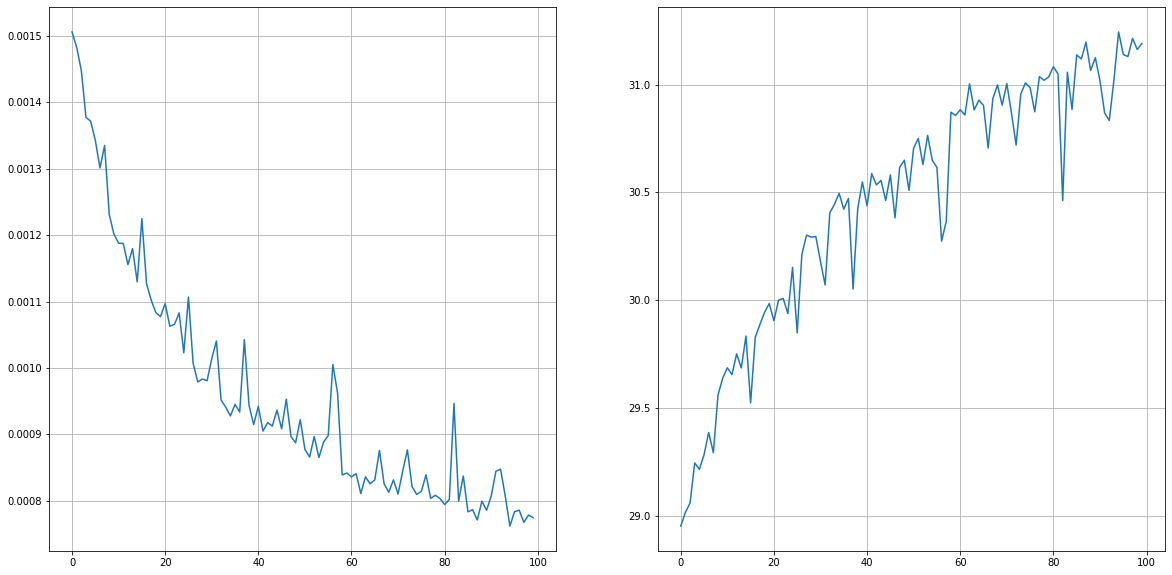

In [53]:
(fig, axes) = plt.subplots(nrows=1, ncols=2, figsize=(20,10))
axes[0].plot(history['loss'])
axes[0].grid('on')

axes[1].plot(history['psnr'])
axes[1].grid('on')

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([256, 256, 3])


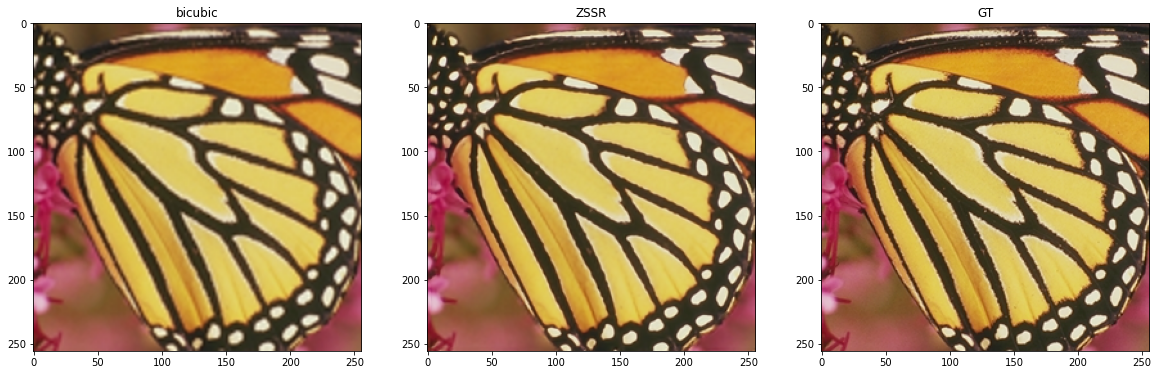

In [56]:
def get_hr_lr_pairs(hr_path, lr_path=None, srf=2):
    og = Image.open(hr_path)
    h, w = og.size
    if lr_path:
        lr = Image.open(lr_path)
    else:
        lr = og.resize((h//srf, w//srf),
                  Image.BICUBIC)
    lr = lr.resize((og.size[0], og.size[1]),
                  Image.BICUBIC)
    return og, lr

sr_factor = 2
og, img = get_hr_lr_pairs(OG_IMG_PATH, srf=sr_factor)
interpolated = img.copy()
img = tv.transforms.ToTensor()(img).unsqueeze(0)

sr_img = model(img.to(device)).squeeze(0)
sr_img = sr_img.detach().cpu().permute(1, 2, 0)
print(sr_img.shape)
fig, axes = plt.subplots(1, 3, figsize=(20, 20))
im = [interpolated, sr_img, og]
title = ["bicubic", "ZSSR", "GT"]
for i, ax in enumerate(axes):
    ax.set_title(title[i])
    ax.imshow(im[i])

plt.savefig('res_' + OG_IMG_PATH.split(".")[0] + '_ep_' + str(EPOCHS) + '_x' + str(sr_factor))